## Signal Analysis

Initial kernel based on Kaggle kernel: 'Analyze Power Line Signal Like a Physicist'

See vsb_analyze-power-line-signals_parallel.py for HF/LF signal division

In [1]:
import csv
import numpy as np
from numpy.fft import rfft, rfftfreq, irfft
from scipy.interpolate import interp1d
from scipy import fftpack, signal
from scipy.signal import butter, filtfilt, hilbert
from scipy.signal import sosfilt, sosfreqz
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
#import pyarrow.parquet as pq
import pickle
import re
import random
from random import randrange
import gc

In [2]:
filename = 'data/CAX_LogFacies_Test_File.csv'
training_data = pd.read_csv(filename)
training_data

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587
...,...,...,...,...
2199995,CAX_2199995,1095,6999,145.376324
2199996,CAX_2199996,1096,6999,140.877243
2199997,CAX_2199997,1097,6999,111.248162
2199998,CAX_2199998,1098,6999,148.859081


### Single Signal Analysis

In [3]:
well_0 = training_data[training_data['well_id'] == 5000]
sig = np.asarray(well_0.GR.values.tolist())

In [4]:

time_step = 1
time_vec = np.arange(0, 1100, time_step)
f_sampling = 1 / time_step
period = 100.0

/home/walle/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


[]

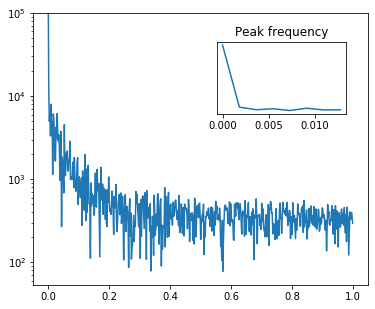

In [5]:
# https://www.scipy-lectures.org/intro/scipy/auto_examples/plot_fftpack.html
# The FFT of the signal
sig_fft = fftpack.fft(sig)
# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)
# The corresponding frequencies
sample_freq = fftpack.fftfreq(sig.size, d=0.5)

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq >= 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

plt.figure(figsize=(6, 5))
# plt.plot(sample_freq[pos_mask], power[pos_mask])
plt.semilogy(sample_freq[pos_mask], power[pos_mask])
plt.ylim([0, 1e5])

# Check that it does indeed correspond to the frequency that we generate
# the signal with
np.allclose(peak_freq, 1./period)

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.6, 0.3, 0.2])
plt.title('Peak frequency')
plt.plot(freqs[:8], power[:8])
plt.setp(axes, yticks=[])

The inset figure above shows that peak frequency is low.
Next we use a slightly different method (signal.periodogram) and plot the power spectrum in log-log scale, which make more sense. The unit in the y axis is different by a fixed factor. 

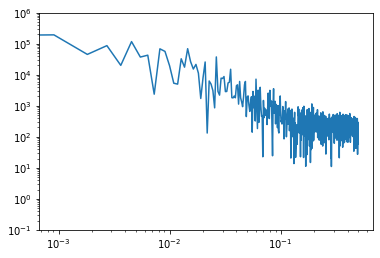

In [6]:
def plot_ps(sig, f_sampling, label='sig', style='loglog'):
    f, Pxx_den = signal.periodogram(sig, f_sampling)
    if style == 'semilogy':
        plt.semilogy(f, Pxx_den, label=label)
    else:
        plt.loglog(f, Pxx_den, label=label)
    plt.ylim([1e-1, 1e6])

    
plot_ps(sig, f_sampling, 'sig')

plt.show()


In [7]:
def bandpassfilter(spec, sample_freq, lowcut, highcut):
    # a digital bandpass filter with a infinite roll off. 
    # Note that we will keep the frequency point right at low cut-off and high cut-off frequencies. 
    #print(f'sample_freq: {sample_freq}')
    spec1 = spec.copy()
    spec1[np.abs(sample_freq) < lowcut] = 0
    spec1[np.abs(sample_freq) > highcut] = 0
    filtered_sig = fftpack.ifft(spec1)
    return filtered_sig

/home/walle/miniconda3/envs/applied_dl_tf/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


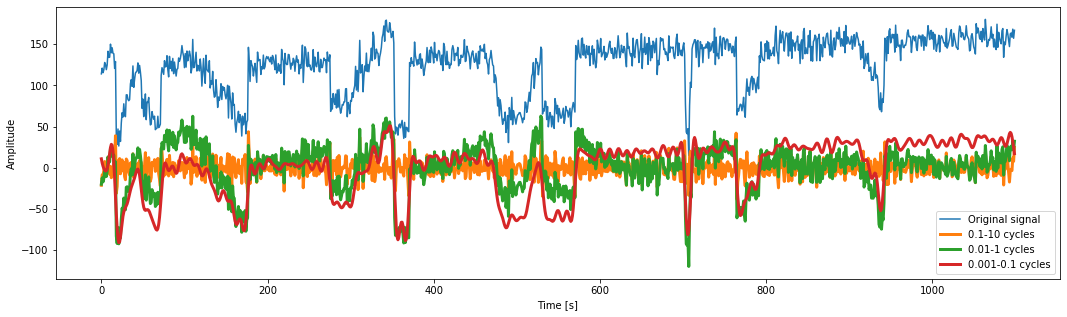

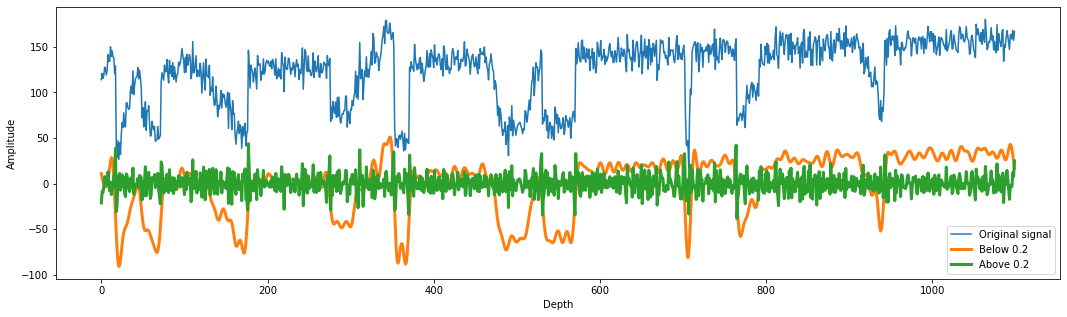

In [8]:
# Digital filtering
# peak_freq should be 50 Hz. 
# We demonstrated differnt low-pass filtered signals. You can see 10-1000 Hz can capture a lot of low frequency features. 
lowcut, highcut = 0.2, 10
filtered_sig0 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 0.01, 1
filtered_sig1 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 0.001, 0.2
filtered_sig2 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)

plt.figure(figsize=(18, 5))
plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sig0, linewidth=3, label='0.1-10 cycles')
plt.plot(time_vec, filtered_sig1, linewidth=3, label='0.01-1 cycles')
plt.plot(time_vec, filtered_sig2, linewidth=3, label='0.001-0.1 cycles')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

# We also demonstrate a band-pass filtered and a high-pass filtered signals. 
lowcut, highcut = 0.2, 10
filtered_sig3 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 0.001, 0.2
filtered_sig4 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
plt.figure(figsize=(18, 5))
plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sig4, linewidth=3, label='Below 0.2')
plt.plot(time_vec, filtered_sig3, linewidth=3, label='Above 0.2')
plt.xlabel('Depth')
plt.ylabel('Amplitude')
plt.legend(loc='best')


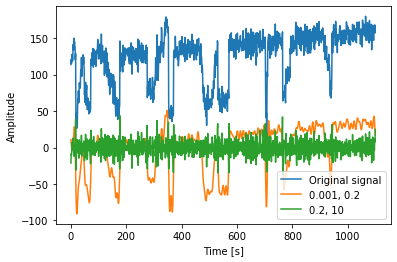

In [9]:
# We also demonstrate a band-pass filtered and a high-pass filtered signals. 
lowcut, highcut = 0.001, 0.2
filtered_sig1 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 0.2, 10
filtered_sig2 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 10, 1000
filtered_sig3 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
lowcut, highcut = 1000, 40e6

plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sig1, label='0.001, 0.2')
plt.plot(time_vec, filtered_sig2, label='0.2, 10')
#plt.plot(time_vec, filtered_sig4, linewidth=3, label='1 KHz-40 MHz')
#plt.plot(time_vec, filtered_sig3, linewidth=3, label='1 kHz-1 MHz')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

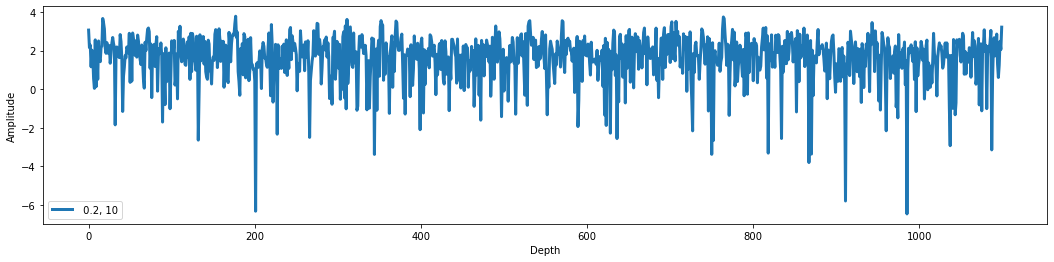

In [10]:
# We also demonstrate a band-pass filtered and a high-pass filtered signals. 
lowcut, highcut =  0.2, 10
filtered_sig3 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
nlog_3 = np.log(filtered_sig3)
plt.figure(figsize=(18,4))
plt.plot(time_vec, nlog_3, linewidth=3, label=' 0.2, 10')
plt.xlabel('Depth')
plt.ylabel('Amplitude')
plt.legend(loc='best')

### Trail of different frequency high cutoffs

0.01 is too low

0.03 lot of HF signal remaining but may be OK to use

need to keep down to 0.0001 frequency to keep the low trend

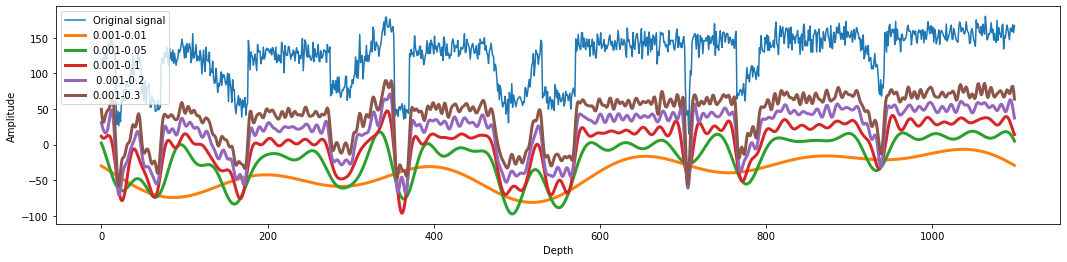

In [11]:

lowcut, highcut =  0.0001, 0.01
filtered_sigpt01 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
filtered_sigpt01=filtered_sigpt01-40
plt.figure(figsize=(18,4))
plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sigpt01, linewidth=3, label='0.001-0.01')

lowcut, highcut =  0.0001, 0.05
filtered_sigpt05 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
filtered_sigpt05=filtered_sigpt05-20
plt.plot(time_vec, filtered_sigpt05, linewidth=3, label='0.001-0.05')

lowcut, highcut =  0.0001, 0.1
filtered_sigpt1 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
plt.plot(time_vec, filtered_sigpt1, linewidth=3, label='0.001-0.1')

lowcut, highcut =  0.0001, 0.2
filtered_sigpt2 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
filtered_sigpt2=filtered_sigpt2+20
plt.plot(time_vec, filtered_sigpt2, linewidth=3, label=' 0.001-0.2')

lowcut, highcut =  0.0001, 0.3
filtered_sigpt3 = bandpassfilter(sig_fft,sample_freq, lowcut, highcut)
filtered_sigpt3=filtered_sigpt3+40
plt.plot(time_vec, filtered_sigpt3, linewidth=3, label='0.001-0.3')


plt.xlabel('Depth')
plt.ylabel('Amplitude')
plt.legend(loc='best')

In [12]:
hf_sigpt05 = sig-filtered_sigpt05
hf_sigpt1 = sig-filtered_sigpt1 + 20
hf_sigpt2 = sig-filtered_sigpt2 + 40
hf_sigpt3 = sig-filtered_sigpt3 + 60

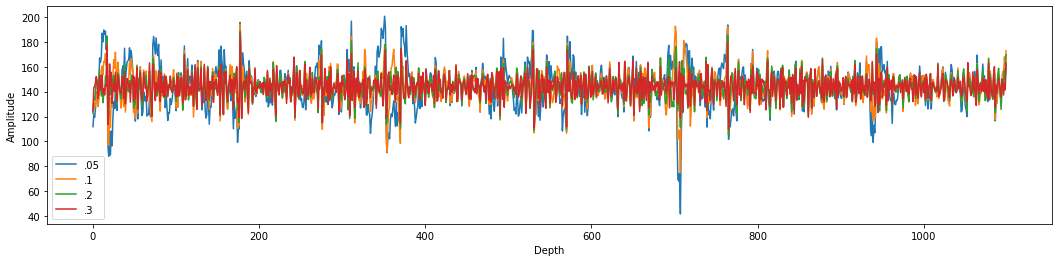

In [13]:
plt.figure(figsize=(18,4))
#some signal still evident in the HF component
plt.plot(time_vec, hf_sigpt05, label='.05')
#some signal still evident in the HF component
plt.plot(time_vec, hf_sigpt1, label='.1')
plt.plot(time_vec, hf_sigpt2, label='.2')
plt.plot(time_vec, hf_sigpt3, label='.3')

plt.xlabel('Depth')
plt.ylabel('Amplitude')
plt.legend(loc='best')

Text(0, 0.5, 'Amplitude')

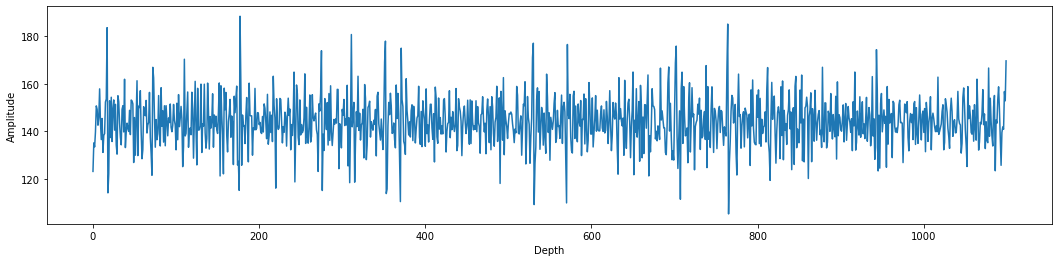

In [14]:
plt.figure(figsize=(18,4))
plt.plot(time_vec, hf_sigpt2, label='hf_sigpt2')

plt.xlabel('Depth')
plt.ylabel('Amplitude')

In [15]:
sample_freq = fftpack.fftfreq(sig.size, d=time_step)

In [16]:
sample_freq[:10]

array([0.        , 0.00090909, 0.00181818, 0.00272727, 0.00363636,
       0.00454545, 0.00545455, 0.00636364, 0.00727273, 0.00818182])

In [17]:
sig.size

1100

In [18]:
def plot_hf_lf(hf, lf, sig):
    plt.figure(figsize=(18,4))
    time_vec=range(len(hf))
    plt.plot(time_vec, sig, label='sig')
    plt.plot(time_vec, hf, label='hf')
    plt.plot(time_vec, lf, label='lf')
    plt.xlabel('Depth')
    plt.ylabel('Amplitude')
    plt.show()

In [19]:
def gen_hf_lf_components(sig, sig_fft, sample_freq, sig_mean, hicut_freqs=[0.05, 0.1, 0.2, 0.3], lowcut = 0.0001, plot=False):
    lf_sigs=[]
    hf_sigs=[]
    for highcut in hicut_freqs:
        lf_sig = bandpassfilter(sig_fft, sample_freq, lowcut, highcut)
        hf_sig = sig-lf_sig
        if plot:
            plot_hf_lf(hf_sig, lf_sig, sig)
        #lf_sigs.append(lf_sig.real+sig_mean)
        lf_sigs.append(lf_sig.real)
        hf_sigs.append(hf_sig.real)
    return lf_sigs, hf_sigs, hicut_freqs

In [20]:
def gen_hf_lf_gr_logs(well_ids):
    frames=[]
    for i, well_id in enumerate(well_ids):
        if (i % 1000)==0:
            print(f'iteration {i}')
        well_df = training_data[training_data['well_id'] == well_id]
        sig = np.asarray(well_df.GR.values.tolist())
        sig_mean=sig.mean()
        sample_freq = fftpack.fftfreq(sig.size, d=time_step)
        sig_fft = fftpack.fft(sig)
        if i==0:
            plot=True
        else:
            plot=False
        lf_sigs, hf_sigs, hicut_freqs= gen_hf_lf_components(sig, sig_fft, sample_freq, sig_mean, plot=plot)
        for lf, hf, hfn in zip(lf_sigs, hf_sigs, hicut_freqs):
            well_df[f'lf_{hfn}']=lf
            well_df[f'hf_{hfn}']=hf
        frames.append(well_df)
    result = pd.concat(frames)
    result.to_csv(f'data/test_wells_plus_{len(hicut_freqs)}_hf_lf_signals.csv', index=False)
    return result

iteration 0


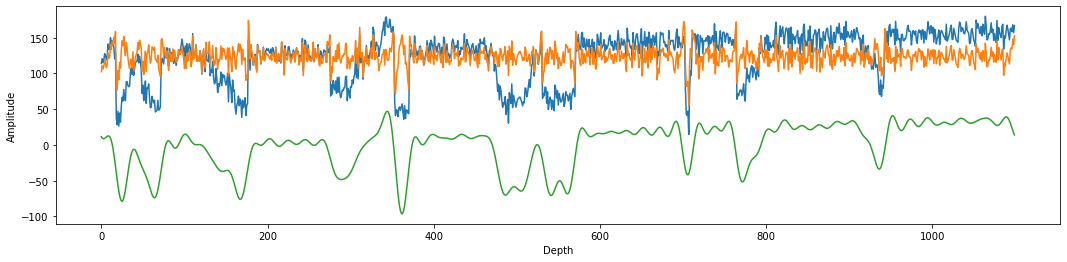

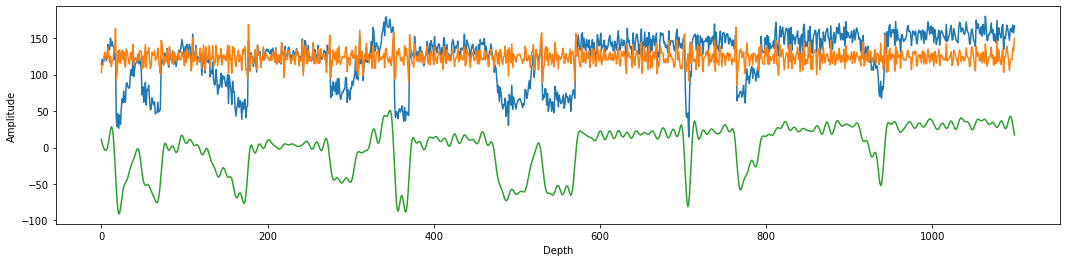

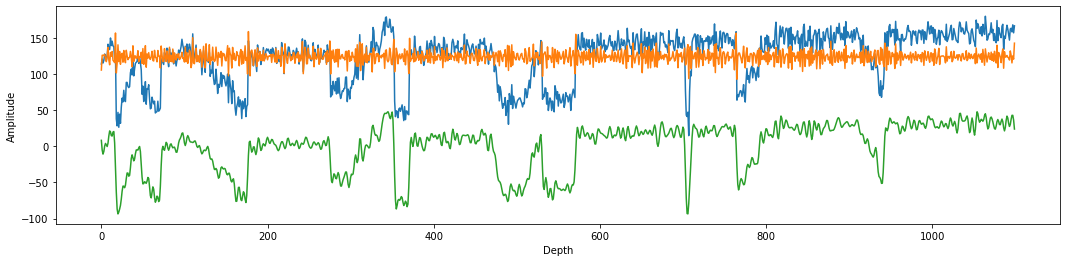

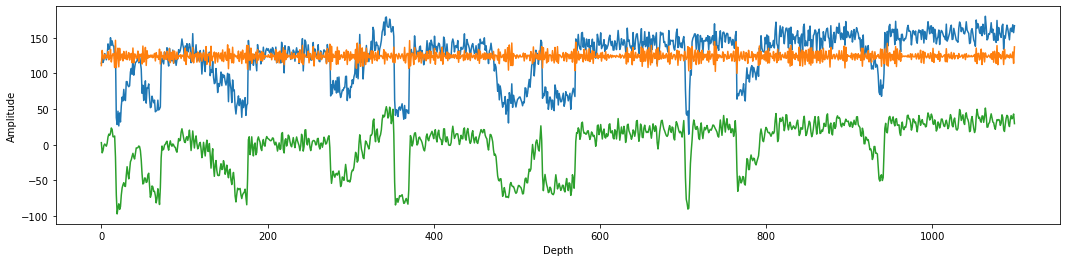

/home/walle/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/walle/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


iteration 1000


,unique_id,row_id,well_id,GR,lf_0.05,hf_0.05,lf_0.1,hf_0.1,lf_0.2,hf_0.2,lf_0.3,hf_0.3
0,CAX_0,0,5000,113.950000,11.599282,102.350718,10.850053,103.099947,8.318825,105.631175,2.961527,110.988473
1,CAX_1,1,5000,120.896397,9.922434,110.973963,5.773798,115.122599,-5.210620,126.107017,-11.285110,132.181507
2,CAX_2,2,5000,115.342793,8.982378,106.360415,1.900677,113.442117,-10.727509,126.070302,-7.986951,123.329744
3,CAX_3,3,5000,118.859190,8.755106,110.104084,-0.969901,119.829091,-6.936418,125.795608,-1.169313,120.028503
4,CAX_4,4,5000,127.735587,9.141973,118.593614,-2.965978,130.701565,0.543134,127.192453,1.074285,126.661302
...,...,...,...,...,...,...,...,...,...,...,...,...
2199995,CAX_2199995,1095,6999,145.376324,29.761939,115.614385,31.567222,113.809102,35.047803,110.328521,42.097813,103.278511
2199996,CAX_2199996,1096,6999,140.877243,27.315918,113.561325,31.404670,109.472573,34.936882,105.940361,30.538807,110.338436
2199997,CAX_2199997,1097,6999,111.248162,24.838925,86.409237,30.446543,80.801618,31.928363,79.319799,26.201316,85.046846
2199998,CAX_2199998,1098,6999,148.859081,22.503722,126.355359,28.510765,120.348316,27.005453,121.853628,32.856591,116.002490


In [21]:
well_ids=training_data.well_id.unique().tolist()
gen_hf_lf_gr_logs(well_ids)

In [22]:
gc.collect()

0

### create augmented signals

In [23]:
df_hf_lf=pd.read_csv(f'data/test_wells_plus_4_hf_lf_signals.csv')

In [24]:
df_hf_lf.head()

,unique_id,row_id,well_id,GR,lf_0.05,hf_0.05,lf_0.1,hf_0.1,lf_0.2,hf_0.2,lf_0.3,hf_0.3
0,CAX_0,0,5000,113.950000,11.599282,102.350718,10.850053,103.099947,8.318825,105.631175,2.961527,110.988473
1,CAX_1,1,5000,120.896397,9.922434,110.973963,5.773798,115.122599,-5.210620,126.107017,-11.285110,132.181507
2,CAX_2,2,5000,115.342793,8.982378,106.360415,1.900677,113.442117,-10.727509,126.070302,-7.986951,123.329744
3,CAX_3,3,5000,118.859190,8.755106,110.104084,-0.969901,119.829091,-6.936418,125.795608,-1.169313,120.028503
4,CAX_4,4,5000,127.735587,9.141973,118.593614,-2.965978,130.701565,0.543134,127.192453,1.074285,126.661302


TODO add HF back onto LF component - but use random, rotated HF components to add back on

In [25]:
def get_rand_hf_data(df, well_ids, hi_cut_val='0.3'):
    well_id=random.choice(well_ids)
    well_df = df[df['well_id'] == well_id]
    hf_data=well_df[f'hf_{hi_cut_val}'].values.tolist()
    return hf_data

In [26]:
def gen_new_hf_sig(hf_data):
    '''roll the hf component'''
    ri=random.randint(10, 400)
    xs=np.asarray(hf_data)
    shifted_hf=np.roll(xs,ri)
    return shifted_hf

In [27]:

def create_new_signals(df, well_ids, hicut_freqs=[0.05, 0.1, 0.2, 0.3]):
    frames=[]
    for well_id in well_ids:
        #pick a well at random, get its hf component
        well_df = df[df['well_id'] == well_id]
        #[0.05, 0.1, 0.2, 0.3]
        components=[0.2, 0.3]
        hf_data=get_rand_hf_data(df, well_ids, hi_cut_val=random.choice(components))
        assert len(hf_data)==1100
        for lf in [0.05, 0.1, 0.2, 0.3]:
            new_hf=gen_new_hf_sig(hf_data)
            assert len(new_hf)==1100
            well_df[f'reco_{lf}']=well_df[f'lf_{lf}']+new_hf
        frames.append(well_df)
    result = pd.concat(frames)
    result.to_csv(f'data/test_wells_{len(hicut_freqs)}_hf_lf_signals_recombined.csv', index=False)

In [28]:
well_ids=training_data.well_id.unique().tolist()
create_new_signals(df_hf_lf, well_ids)

/home/walle/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [29]:
gc.collect()

0

In [30]:
### Check and refine

In [31]:
df_hf_lf=pd.read_csv(f'data/test_wells_4_hf_lf_signals_recombined.csv')

In [32]:
df_hf_lf.head()

,unique_id,row_id,well_id,GR,lf_0.05,hf_0.05,lf_0.1,hf_0.1,lf_0.2,hf_0.2,lf_0.3,hf_0.3,reco_0.05,reco_0.1,reco_0.2,reco_0.3
0,CAX_0,0,5000,113.950000,11.599282,102.350718,10.850053,103.099947,8.318825,105.631175,2.961527,110.988473,124.643597,124.045287,121.967726,121.441932
1,CAX_1,1,5000,120.896397,9.922434,110.973963,5.773798,115.122599,-5.210620,126.107017,-11.285110,132.181507,121.910897,120.924764,113.096632,108.238522
2,CAX_2,2,5000,115.342793,8.982378,106.360415,1.900677,113.442117,-10.727509,126.070302,-7.986951,123.329744,133.477859,119.799119,104.846878,95.956203
3,CAX_3,3,5000,118.859190,8.755106,110.104084,-0.969901,119.829091,-6.936418,125.795608,-1.169313,120.028503,116.270192,117.175449,107.785320,127.112697
4,CAX_4,4,5000,127.735587,9.141973,118.593614,-2.965978,130.701565,0.543134,127.192453,1.074285,126.661302,129.931423,104.813594,115.440966,116.910471


In [33]:
len(df_hf_lf)

2200000

In [34]:
len(df_hf_lf.well_id.unique())

2000